In [1]:
import ray
import time
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.algorithms.callbacks import DefaultCallbacks
from ray.rllib.models import ModelCatalog
from ray.rllib.utils.framework import try_import_torch
from ray.rllib.algorithms.ppo import PPOConfig
from ray import tune, air
from ray.rllib.core.models.configs import MLPHeadConfig
from ray.rllib.core.models.catalog import Catalog
from ray.rllib.models.torch.fcnet import FullyConnectedNetwork as TorchFC
from ray.rllib.utils.annotations import OverrideToImplementCustomLogic
from gymnasium.spaces import Box
from ray.rllib.examples.models.centralized_critic_models import YetAnotherTorchCentralizedCriticModel
from ray.train.torch import TorchTrainer
from ray.train import ScalingConfig
import ray.rllib.algorithms.ppo as ppo
from ray.rllib.utils.typing import Dict, TensorType, List, ModelConfigDict
import gymnasium as gym
import matplotlib.pyplot as plt
from ray.rllib.models.torch.misc import SlimFC, AppendBiasLayer
from ray.rllib.policy.torch_policy import TorchPolicy
from ray.rllib.policy.policy_template import build_policy_class
from ray.rllib.policy.sample_batch import SampleBatch
import numpy as np
from ray import tune
import math
from torch.distributions.normal import Normal

C:\Users\TylerLaurie\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Data flow: obs -> forward() -> model_out \-> value_function() -> V(s)

In [2]:
torch, nn = try_import_torch()

In [3]:
ray.init()

2024-02-13 10:56:57,915	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.11.4
Ray version:,2.9.1
Dashboard:,http://127.0.0.1:8265


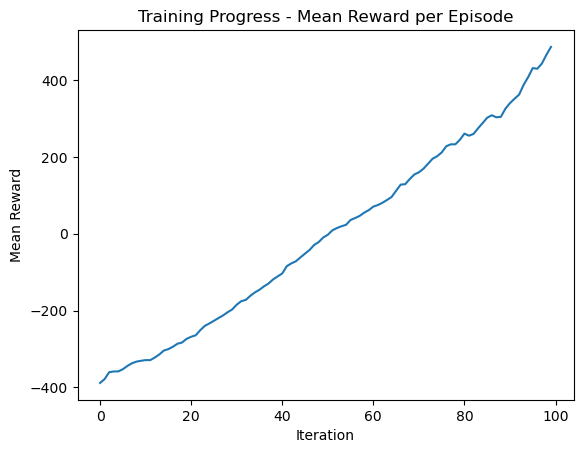

In [142]:
plt.plot(rewards)
plt.title('Training Progress - Mean Reward per Episode')
plt.xlabel('Iteration')
plt.ylabel('Mean Reward')
# plt.savefig('Basic PPO - HalfCheetah-v4')
plt.show()

### MOG and Entropy Loss

In [15]:
global adder
adder = 1.000001
global num_gaussians
num_gaussians = 5

class CustomTorchModelMOG(TorchModelV2, nn.Module):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        super(CustomTorchModelMOG, self).__init__(obs_space, action_space, num_outputs, model_config, name)
        
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs, model_config, name)
        
        nn.Module.__init__(self)
        
        self.actor_fcnet = TorchFC(obs_space, action_space, 2, model_config, name + "_actor")
        
        self.critic_fcnet = TorchFC(obs_space, action_space, num_gaussians*3, model_config, name + "_critic")
        
        self.loss_list = []
        
        '''
        Get the output from fcnet, which is tuple of the new state and the the output of
        the FullyConnectedLayer module under ray.rllib.models.torch.fcnet.py
        -->This output is from the inherited modelv2 from ray.rllib.models.modelv2.py
        ---which consists of outputs from calling self.foward as well as the state_out information
        ---which is the current (next) state
        

        -The input_dict contains complex observations (obs_flat, prev_action, prev_reward, is_training,
        -eps_id, agent_id, infos, and t) which will be unpacked by __call__ in modelv2 before being 
        -passed to the foward pass
        
        -State includes the list of state tensors with sizes matching those returned by get_initial_state
        + the batch dimension
        
        -seq_lens is a 1d tensor holding input sequence lengths
        
        -We can access the flattened observation tensor by input_dict['obs_flat']
        
        **Custom models should override forward and not __call__
        **The forward pass has to be performed before the value function call and calling the value
        function does not cause another call on the forward pass
        
        '''
        
    @OverrideToImplementCustomLogic
    def forward(self, input_dict, state, seq_lens):
        # Actor forward pass
        action_logits, _ = self.actor_fcnet(input_dict, state, seq_lens)
        
        # Critic forward pass
        value_output, _ = self.critic_fcnet(input_dict, state, seq_lens)
        
        self.value_ouput_tensor = value_output
        #this is redudnant since it already outputs a tensor
    
        '''
        -value_output is a function of the number of components we wish to have for the MoGs
        --Because of this, it makes sense to have the arrays slice based on the number of components input
          from a user
        '''
        
        #fix this with slicing
        
        elu = torch.nn.ELU()
        
        i = num_gaussians
        means = value_output[:, :i]
        self._u = means
        
        sigmas_prev = value_output[:, i:i*2]
        sigmas = elu(sigmas_prev) + adder
        self._sigmas = sigmas
        
        alphas = value_output[:, i*2:]
        alphas = torch.nn.functional.softmax(alphas, dim=-1)
        self._alphas = alphas
        
        self._first_term = 0.0
        
        
#         u_1, u_2, u_3, sigma_1, sigma_2, sigma_3, alpha_1, alpha_2, alpha_3 = self.value_ouput_tensor.chunk(9, -1)
        
#         sigma_1 = elu(sigma_1) + adder
#         sigma_2 = elu(sigma_2) + adder
#         sigma_3 = elu(sigma_3) + adder
        
#         alpha_1 = alpha_1.float()
#         alpha_2 = alpha_2.float()
#         alpha_3 = alpha_3.float()
#         alphas = torch.nn.functional.softmax(torch.cat([alpha_1, alpha_2, alpha_3], dim=-1), dim=-1)

# #         Store the components for use in the value function
#         self._u = [u_1, u_2, u_3]
#         self._sigmas = [sigma_1, sigma_2, sigma_3]
#         self._alphas = alphas

        return action_logits, state

    @OverrideToImplementCustomLogic
    def value_function(self):
        multiply = self._u * self._alphas
        values = torch.sum(multiply, dim = 1)
        return values
    
    '''
    -We need the sample from MoG as a means of doing the n-step return which is common for reducing
    variance, but at the cost of increasing bias...fortunately, betwen 3-7 samples is enough to 
    approximately have the bias/variance tradeoff nearly equal
    --This is important to do to increase convergence and also decrease computation time compared to
    the Monte Carlo approach which is sampling a bunch of trajectories
    
    -From the sample we need to compute the log probabilites of the samples
    '''

    def predict_gmm_params(self, cur_obs):
        input_dict = {'obs': cur_obs}
        state = []  
        seq_lens = None
        value_output, _ = self.critic_fcnet(input_dict, state, seq_lens)        
        
        elu = torch.nn.ELU()
        
        i = num_gaussians
        means = value_output[:, :i]
        sigmas_prev = value_output[:, i:i*2]
        sigmas = elu(sigmas_prev) + adder
        alphas = value_output[:, i*2:]
        alphas = torch.nn.functional.softmax(alphas, dim=-1)
        
        return means, sigmas, alphas
    
    def generate_target_gmm_params(self, rewards, next_states, dones, gamma=0.99):

        mu_next, sigma_next, w_next = self.predict_gmm_params(next_states)
        mu_target = mu_next + (rewards.unsqueeze(-1) * gamma) * (1 - dones.unsqueeze(-1).float())
        sigma_target = sigma_next
        w_target = w_next
    
        return mu_target.clone().detach(), sigma_target.clone().detach(), w_target.clone().detach()
    
    
#     def compute_cross_entropy(self, mu_pred, sigma_pred, w_pred, mu_target, sigma_target, w_target):
#         """
#         Compute the energy distance between three Gaussian Mixture Models (GMMs) analytically,
#         including internal dispersion terms.
#         """
#         N = mu_u.size(0)
#         N0 = mu_v.size(0)
        
#         input_var, target_var = self.calculate_delta(mu_pred, sigma_pred, w_pred,
#                                                      mu_target, sigma_target, w_target)
        
#         cross_entropy_loss = torch.nn.CrossEntropyLoss(input_var, target_var)
        
    
#         return cross_entropy_loss

#     def calculate_delta(self, mu_pred, sigma_pred, w_pred, mu_target, sigma_target, w_target):
#         """
#         Compute delta for given GMM parameters.
#         """
#         mu_1_expanded = mu_pred.unsqueeze(2)
#         mu_2_expanded = mu_target.unsqueeze(1)

#         sigma_1_expanded = sigma_pred.unsqueeze(2)
#         sigma_2_expanded = sigma_target.unsqueeze(1)

#         w_1_expanded = w_pred.unsqueeze(2)
#         w_2_expanded = w_target.unsqueeze(1) 
        
#         pred_var = (torch.square(sigma_1_expanded))
#         target_var = (torch.square(sigma_2_expanded))
              
#         means_diff = torch.square(mu_pred - mu_target) / pred_var
        
#         scaling_vars = target_var / pred_var
        
#         log_pred = torch.log(pred_var)
        
#         entropy_loss_equiv = means_diff + scaling_vars + log_pred

#         entropy_loss_equiv = torch.sum(w_1_expanded * w_2_expanded * E_Zij, dim = (1,2))
    

#         return entropy_loss_equiv
    
    def compute_log_likelihood(self, td_targets, mu_current, sigma_current, alpha_current):
        
        N = mu_current.size(0)
        td_targets_expanded = td_targets.unsqueeze(1) 
        #[2048, 1]
        mu_current_expanded = mu_current
        #no need to unsqueeze this since the td_target is only dimension 2048x1
        #[2048, 5, 1]
        sigma_current_expanded = sigma_current 
        alpha_current_expanded = alpha_current 
        
        '''
        Important here: we have a mix of shapes of the arrays since td_targets will be [N,1] and the
        mu_current will be [N,num_gaussians] so we have to do the same trick to get a matrix which
        has all of these compared (such as the 2048x3x1 + 2048x1x3 but two dimensions not three)
        
        td_targets =                            [N]
        td_targets_expanded =                  [N,1]
        sigma_current =                   [N, num_gaussians]
        sigma_current_expanded =        [N, num_gaussians, 1]
        alpha_current_expanded =        [N, num_gaussians, 1]
        when subtracted =               [N, num_gaussians, 1] for the exp()
        '''

        var = sigma_current_expanded ** 2
        vars_clamped = torch.clamp(var, -1e-8, 1e4)

        factor = 1.0 / torch.sqrt(2 * torch.pi * vars_clamped)
        exponent = torch.exp(-((td_targets_expanded - mu_current_expanded) ** 2) / (2 * vars_clamped))
        densities = factor * exponent  # Shape: [N, num_gaussians, 1]

        weighted_densities = densities * alpha_current_expanded

        # Sum over mixture components to get total density per sample
        total_density = weighted_densities.sum(dim=1)  # Shape: [N, 1]

        # Compute log likelihood
        log_likelihood = torch.log(total_density)
        
        log_likelihood_sum = log_likelihood.sum() / N

        return log_likelihood_sum


    @OverrideToImplementCustomLogic
    def custom_loss(self, policy_loss, sample_batch):
        
        gamma = 0.99
        cur_obs = sample_batch[SampleBatch.CUR_OBS]
        next_states = sample_batch[SampleBatch.NEXT_OBS]
        rewards = sample_batch[SampleBatch.REWARDS]
        dones = sample_batch[SampleBatch.DONES]

        mu_current, sigma_current, alpha_current = self.predict_gmm_params(cur_obs)
        mu_next, sigma_next, alpha_next = self.predict_gmm_params(next_states)

        next_state_values = torch.sum(mu_next * alpha_next, dim=1)
        td_targets = rewards + gamma * next_state_values * (1 - dones.float())

        log_likelihood = self.compute_log_likelihood(td_targets, mu_current, sigma_current, alpha_current)

        cross_entropy_loss = -torch.mean(log_likelihood)
        
        total_loss = [loss + cross_entropy_loss for loss in policy_loss]
        
        '''
        Tought: what if I use another neural network to determine the weights for each of the
        loss terms? I.e. have a layer of [64,64] with two inputs and two outputs ran through a softmax
        layer
        
        Tried this, but didn't seem to work
        '''

        
        return total_loss

'''
Fixes:
(1) added in the TD bootstrap instead of the Monte Carlo estimation (DeepMind used M.C.)
(2) cross-entropy loss as the loss function instead of the Cramer distance
(3) dimensions for log likelihood calculations checked (recheck tomorrow)
'''


'\nFixes:\n(1) added in the TD bootstrap instead of the Monte Carlo estimation (DeepMind used M.C.)\n(2) cross-entropy loss as the loss function instead of the Cramer distance\n(3) dimensions for log likelihood calculations checked (recheck tomorrow)\n'

In [16]:
ModelCatalog.register_custom_model("custom_torch_model_mog", CustomTorchModelMOG)

In [17]:
config = PPOConfig().training(
    gamma = 0.99,
    lambda_ = 0.95,
    kl_coeff = 1.0,
    num_sgd_iter = 32,
    lr= [[0, 0.0003], [1_000_000, 0.0002]],
    vf_loss_coeff = 1.0,
#     vf_clip_param = 1.0,
#     clip_param = 0.2,
    clip_param = 0.4,
    grad_clip_by='norm', 
    train_batch_size=8192, 
    sgd_minibatch_size=2048,
    grad_clip = 1.0,
    model={'custom_model': 'custom_torch_model_mog', 
    'vf_share_layers': False, 'fcnet_hiddens': [256,256],'fcnet_activation': 'LeakyReLU'}
).environment(env='HalfCheetah-v4'
).rollouts(
num_rollout_workers = 2,
num_envs_per_worker = 4,
)

num_iterations = 300

algo = config.build()
rewards = []

for i in range(num_iterations):
    result = algo.train()
    print(f"Iteration: {i}, Mean Reward: {result['episode_reward_mean']}")
    rewards.append(result['episode_reward_mean'])
    
ray.shutdown()

(pid=27116) C:\Users\TylerLaurie\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
(pid=27116)   "class": algorithms.Blowfish,
(RolloutWorker pid=27116) C:\Users\TylerLaurie\anaconda3\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.single_observation_space to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.single_observation_space` for environment variables or `env.get_wrapper_attr('single_observation_space')` that will search the reminding wrappers.
(RolloutWorker pid=27116)   logger.warn(
(RolloutWorker pid=27116) C:\Users\TylerLaurie\anaconda3\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.single_action_space to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.single_action_space` for environment variables or `env.get_wrapper_attr('singl

Iteration: 0, Mean Reward: -362.2232806989805
Iteration: 1, Mean Reward: -344.39290344885626
Iteration: 2, Mean Reward: -337.1357996932331
Iteration: 3, Mean Reward: -323.83020104074774
Iteration: 4, Mean Reward: -298.6799359998051
Iteration: 5, Mean Reward: -278.66762908780794
Iteration: 6, Mean Reward: -246.15199763928533
Iteration: 7, Mean Reward: -234.6621496769157
Iteration: 8, Mean Reward: -194.7384072678086
Iteration: 9, Mean Reward: -176.54184612111254
Iteration: 10, Mean Reward: -159.5137632078339
Iteration: 11, Mean Reward: -112.63644425616768
Iteration: 12, Mean Reward: -75.99649176957416
Iteration: 13, Mean Reward: -23.80765850291873
Iteration: 14, Mean Reward: 19.914359530639327
Iteration: 15, Mean Reward: 77.46427506847049
Iteration: 16, Mean Reward: 118.2012530911799
Iteration: 17, Mean Reward: 149.00404393391386
Iteration: 18, Mean Reward: 192.53034818050207
Iteration: 19, Mean Reward: 241.22992647847022
Iteration: 20, Mean Reward: 268.22505112180136
Iteration: 21, Mean

(pid=31596) C:\Users\TylerLaurie\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
(pid=31596)   "class": algorithms.Blowfish,
(RolloutWorker pid=31596) C:\Users\TylerLaurie\anaconda3\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.single_observation_space to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.single_observation_space` for environment variables or `env.get_wrapper_attr('single_observation_space')` that will search the reminding wrappers.
(RolloutWorker pid=31596)   logger.warn( [repeated 2x across cluster]
(RolloutWorker pid=31596) C:\Users\TylerLaurie\anaconda3\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.single_action_space to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.single_action_space` for environment variables or

### first tune parameter search for vf_loss_coefficient gave vf_loss_coefficient = 0.5 as the best for 0.1, 0.5, 1.0

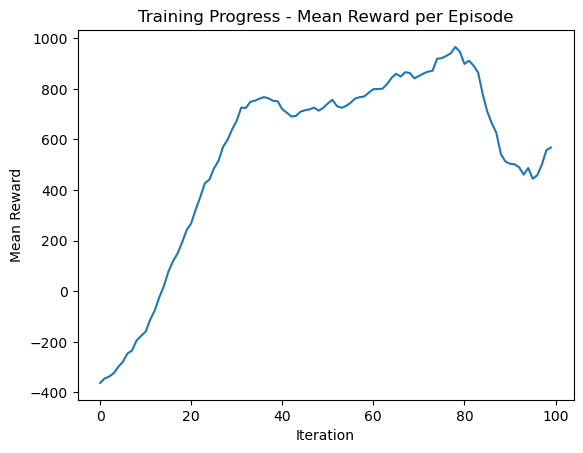

In [19]:
plt.plot(rewards)
plt.title('Training Progress - Mean Reward per Episode')
plt.xlabel('Iteration')
plt.ylabel('Mean Reward')
# plt.savefig('MOG and Energy Distance - HalfCheetah-v4')
plt.show()

In [24]:
import pandas as pd

In [25]:
cross_entropy_normalized = pd.DataFrame(rewards)

In [26]:
cross_entropy_normalized.to_csv('results/cross_entropy_normalized.csv')

In [28]:
cross_entropy_rewards = pd.read_csv('results/cross_entropy_rewards.csv')

In [21]:
import plotly.express as px
import plotly.graph_objects as go
import kaleido

In [33]:
fig = go.Figure()

# fig.add_trace(go.Scatter(y = rewards, mode = 'lines', name = 'Rewards'))
fig.add_trace(go.Scatter(y = cross_entropy_normalized[0], mode = 'lines', name = 'Normalized cross entropy'))
fig.add_trace(go.Scatter(y = cross_entropy_rewards['0'], mode = 'lines', name = 'Cross entropy'))

fig.update_layout(title_text="Cross Entropy Loss", xaxis_title = 'Iterations', yaxis_title = 'Rewards',
                 font = dict(
                     family = 'Times New Roman',
                     size = 18,
                 ))
# fig.write_image('/MoG_Performance.png')
#no internal dispersion and not normalized by N*N
fig.show()